## Assignment 6: Factor models

## Exercise 1

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
from matplotlib.pyplot import cm
import matplotlib.dates as mdates
db=wrds.Connection(wrds_username='zak_souid')
#db.create_pgpass_file()


Loading library list...
Done


### Download and format data

In [2]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1980-01-01'
            and mcaldt<='2022-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

In [3]:
#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1980-01-01' and date<='2022-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})




In [4]:
#---------------------------------------------
# Stock Returns 
#---------------------------------------------

stock_data = db.raw_sql("""
                    select a.permno, a.date, a.ret, a.shrout, a.prc, b.siccd 
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1980' and '12/31/2022'
                      """, date_cols=['date']) 
stock_data = stock_data.rename(columns={'ret':'Rn'})
# Restrict to SP500 
SP500_constituents = db.get_table(library='crsp', table='msp500list')
sp500 = pd.merge(SP500_constituents, stock_data,on=['permno'], how='left')
sp500['ending'] = sp500['ending'].fillna(sp500.date.max())
sp500 = sp500[(sp500.date >= sp500.start) & (sp500.date <= sp500.ending)].copy()

In [2]:
#---------------------------------------------
# Industry Definitions  and Returns 
#---------------------------------------------
Industry_Returns = pd.read_csv('12_Industry_Portfolios.txt', delimiter= '\s+')
Industry_Definitions = pd.read_csv('48_Industries.csv')
Industry_Definitions = Industry_Definitions.rename(columns={'SIC':'siccd'})
Industries = Industry_Returns.columns.tolist()
Industry_Names = pd.DataFrame(Industries,index=np.arange(1,13)).reset_index()
Industry_Names.columns=['Industry','Name']
Industry_Returns = Industry_Returns.reset_index().rename(columns = {'index':'dateM'})
Industry_Returns['dateM'] = pd.to_datetime(Industry_Returns['dateM'], format='%Y%m', errors='coerce')

### Merge different data-sources

In [6]:
#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(sp500, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data = pd.merge(data, Industry_Definitions[['siccd','FF_12']],on=['siccd'], how='left')
data['dateM'] = data['date'].apply(lambda x: pd.to_datetime(str(x)))             #astype('datetime64[M]')
data = pd.merge(data, Industry_Returns,on=['dateM'], how='left')

#---------------------------------------------
# Define Variables and drop obs
#---------------------------------------------
data = data.sort_values(['permno','date'])
data['mcap'] = np.abs(data['prc'])*data['shrout']
data['mcap_l'] = data.groupby(['permno'])['mcap'].shift(1)
data['Rn_f'] = data.groupby(['permno'])['Rn'].shift(-1)
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data['w_m'] = data['mcap_l']/data.groupby(['date'])['mcap_l'].transform('sum')
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e','FF_12']).copy()

In [43]:
data

,permno,start,ending,date,Rn,shrout,prc,siccd,rf,Rm,...,Rm_e,w_m,shifted_Rn,Rn_12m,offset12,mom,w_long,w_short,w_mom,mom_ret
0,10006.0,1957-03-01,1984-07-18,1981-02-27,-0.022059,9009.0,49.875000,3743.0,0.011762,0.015519,...,0.003757,0.000523,0.108696,0.378282,1981-02-01,7,0.0,0.000000,0.000000,-0.024243
1,10057.0,1957-03-01,1992-07-02,1981-02-27,-0.005941,4273.0,24.750000,3541.0,0.011762,0.015519,...,0.003757,0.000123,-0.009804,0.030314,1981-02-01,1,0.0,0.000000,0.000000,-0.024243
2,10145.0,1925-12-31,2022-12-30,1981-02-27,0.076000,33489.0,53.250000,2812.0,0.011762,0.015519,...,0.003757,0.001905,-0.065421,-0.030412,1981-02-01,0,0.0,0.024772,-0.024772,-0.024243
3,10153.0,1977-06-30,1987-07-08,1981-02-27,-0.029630,12457.0,32.750000,3511.0,0.011762,0.015519,...,0.003757,0.000478,-0.072165,0.299999,1981-02-01,6,0.0,0.000000,0.000000,-0.024243
4,10161.0,1957-03-01,1993-11-12,1981-02-27,-0.065487,62084.0,39.000000,1011.0,0.011762,0.015519,...,0.003757,0.002993,0.027273,-0.171500,1981-02-01,0,0.0,0.038920,-0.038920,-0.024243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238296,93096.0,2012-12-03,2022-12-30,2022-12-30,-0.034731,223575.0,246.250000,5331.0,0.003332,-0.057116,...,-0.060447,0.001619,0.002470,0.119053,2022-12-01,7,0.0,0.000000,0.000000,0.105688
238297,93132.0,2018-10-11,2022-12-30,2022-12-30,-0.080324,781236.0,48.889999,9999.0,0.003332,-0.057116,...,-0.060447,0.001166,-0.069979,-0.223699,2022-12-01,2,0.0,0.000000,0.000000,0.105688
238298,93246.0,2021-03-22,2022-12-30,2022-12-30,-0.046058,63356.0,100.660004,3621.0,0.003332,-0.057116,...,-0.060447,0.000188,-0.089639,-0.956740,2022-12-01,0,0.0,0.002071,-0.002071,0.105688
238299,93429.0,2017-03-01,2022-12-30,2022-12-30,-0.010801,106082.0,125.470001,6211.0,0.003332,-0.057116,...,-0.060447,0.000378,0.022811,0.000201,2022-12-01,5,0.0,0.000000,0.000000,0.105688


# Construct Momentum Strategy

Cumulative 12 month past return for each stock:

In [3]:
#data.to_csv('PS6_Data.csv',index=False)
data = pd.read_csv('PS6_Data.csv')


In [11]:
df1 = data.copy(deep=True)
df1['Ln_Rn']=np.log(df1['Rn']+1)
df1['cLn_Rn'] = df1.groupby(['permno'])['Ln_Rn'].shift(1).rolling(11, min_periods=11).sum().reset_index(0,drop=True)
df1.dropna(subset=['cLn_Rn'],inplace=True)
# compound return in %
df1['c_Rn']=np.exp(df1['cLn_Rn'])-1
#...Construct momentum return here. Also construct and store the explicit weights here (you will need them later)
df1['decile']=df1.groupby(['date'])['cLn_Rn'].transform(lambda x: pd.qcut(x,10,labels=False,))
# where df1['decile']==9, we have the largest return between t−12 and t−1 month, we go long
# where df1['decile']==0, we have the smallest return between t−12 and t−1 month, we go short
df1['pos']=df1['decile'].apply(lambda x: 1 if x==9 else -1 if x==0 else 0) 
#df1['mcap_0and9']=np.abs(df1['pos']*df1['mcap'])
df1['mom_w']=df1['pos']*df1['mcap_l']/df1.groupby(['date','decile'])['mcap_l'].transform('sum')
df1['Rn_ln']=np.log(df1['Rn']+1)
df1['strat_ret']=df1['mom_w']*df1['Rn']

#...Compute the cumulative return of the strategy here
momentum=df1.groupby(['date'])['strat_ret'].apply(lambda x : np.sum(x))


In [12]:
df1

,permno,start,ending,date,Rn,shrout,prc,siccd,rf,Rm,...,Rm_e,w_m,Ln_Rn,cLn_Rn,c_Rn,decile,pos,mom_w,Rn_ln,strat_ret
11,10006.0,1957-03-01,1984-07-18,1981-01-30,0.108696,9009.0,51.000000,3743.0,0.011667,-0.040085,...,-0.051752,0.000451,0.103184,0.166286,0.180910,5,0,0.000000,0.103184,0.000000
12,10006.0,1957-03-01,1984-07-18,1981-02-27,-0.022059,9009.0,49.875000,3743.0,0.011762,0.015519,...,0.003757,0.000523,-0.022306,0.330064,0.391058,7,0,0.000000,-0.022306,-0.000000
13,10006.0,1957-03-01,1984-07-18,1981-03-31,-0.005013,9009.0,49.000000,3743.0,0.010906,0.046183,...,0.035277,0.000504,-0.005025,0.496595,0.643117,8,0,0.000000,-0.005025,-0.000000
14,10006.0,1957-03-01,1984-07-18,1981-04-30,-0.066327,9009.0,45.750000,3743.0,0.011583,-0.011266,...,-0.022849,0.000479,-0.068629,0.519405,0.681026,7,0,0.000000,-0.068629,-0.000000
15,10006.0,1957-03-01,1984-07-18,1981-05-29,0.066995,9009.0,48.125000,3743.0,0.013550,0.013546,...,-0.000003,0.000456,0.064846,0.369493,0.447001,6,0,0.000000,0.064846,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256533,93436.0,2020-12-21,2022-12-30,2022-08-31,-0.072489,3133470.0,275.609985,9999.0,0.001964,-0.036240,...,-0.038204,0.025666,-0.075250,0.192000,0.211670,8,0,0.000000,-0.075250,-0.000000
256534,93436.0,2020-12-21,2022-12-30,2022-09-30,-0.037589,3158000.0,265.250000,9999.0,0.002274,-0.091324,...,-0.093598,0.024908,-0.038314,0.064117,0.066217,7,0,0.000000,-0.038314,-0.000000
256535,93436.0,2020-12-21,2022-12-30,2022-10-31,-0.142168,3157752.0,227.539993,9999.0,0.002885,0.077403,...,0.074518,0.026645,-0.153347,-0.336427,-0.285682,3,0,0.000000,-0.153347,-0.000000
256536,93436.0,2020-12-21,2022-12-30,2022-11-30,-0.144326,3157752.0,194.699997,9999.0,0.003326,0.052365,...,0.049040,0.021199,-0.155866,-0.517012,-0.403700,0,-1,-0.185903,-0.155866,0.026831


Momentum Decile Weights (market-cap weighted)

The portfolio mean return is : 0.04077801981444728
The portfolio standard deviation is : 0.266095359121819
The portfolio SR is : 0.15324588880101067


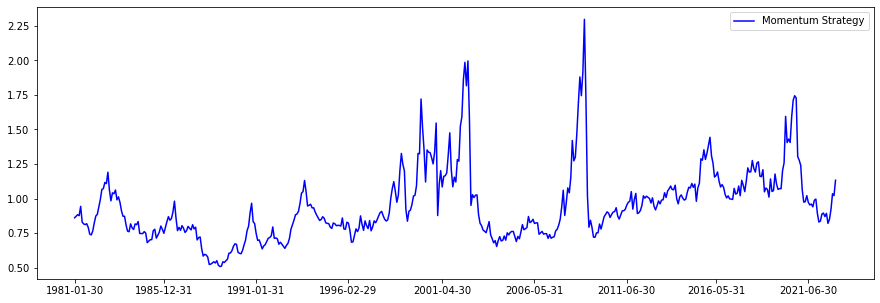

In [13]:
plt.figure(figsize=(15,5))
plt.plot((momentum+1).cumprod(), label='Momentum Strategy', color='blue')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.legend()
plt.show

#compute momentum sharpe ratio, annualized mean return and standard deviation
print('The portfolio mean return is :', momentum.mean()*12)
print('The portfolio standard deviation is :',momentum.std()*np.sqrt(12))
print('The portfolio SR is :', momentum.mean()/momentum.std()*np.sqrt(12))

## Observable Factors

$$R_t^{MOM} = \alpha^{MOM} + \beta^{MOM} F_t + \epsilon_{t}$$

Here we run the following regression where $F_t$ is a contains the 12 industry returns and the return on the market portfolio.This is the "observable factor" approach, in which exposures (unknown) are estimated from a linear regression.

In [17]:
df2 =df1.copy()

In [18]:
# Industry Exposure
import statsmodels.api as sm
RegOLS = sm.OLS(df2['strat_ret'], df2[['const','Rm_e']+Industries]).fit()
#print(RegOLS.summary())
RegBeta = pd.concat([RegOLS.params,RegOLS.tvalues], axis=1)
print('the R2 is:',RegOLS.rsquared)
RegBeta.rename(columns={0:'beta, except for cons',1:'t-stat'},inplace=True)
RegBeta.sort_values(by='beta, except for cons',ascending=False)

the R2 is: 0.002132248522194735


,"beta, except for cons",t-stat
Rm_e,4.370720e-03,7.642795
const,2.883585e-05,6.532243
Shops,5.368612e-06,3.327719
Hlth,2.683016e-06,1.945979
Utils,9.957526e-07,0.793202
NoDur,9.475276e-07,0.495925
Manuf,-2.506244e-06,-1.131161
Other,-2.506292e-06,-1.087035
Chems,-5.642238e-06,-3.109241
Enrgy,-5.914142e-06,-6.794294


Within one single month a factor could be very significant with a very high t stat due to a huge positive shock in that particular month but could also happen the opposite that, cause of a big negative event, the factor has a very low t stat. In both cases the factor is relevant in the cross sectional regression in each month when the absolute value of the t stat is bigger than 2, but then, considering more months, it's not anymore significant of average.
(So we should find that the average t-stat associated with each factor is smaller that the mean of the absolute value of the t statistic (this should hold for sure). Then for high significant factors we should find that the spread between the normal average and the absolute mean is higher wrt the non significant factors)

## Unobservable Factors

Now we estimate the factors from cross-sectional regressions onto known (observable) exposures. As industry exposures we construct dummy variables indicating a stock's affiliation to the industry. Market exposures (betas) are not directly observable and have to be estimated first. 

$$R_{t,n}-R_f = F_t \beta_n  + \epsilon_{t}$$

Here the $\beta_n$ is observable and we estimate the factors $F_t$ from monhtly cross-sectional regressions from $t=1,...,T$. The observable exposures $\beta_n$ contain 12 industry dummies, as well as the market betas of all stocks. 

In [19]:
df3 = df2.copy()

In [20]:
# 1. First compute market beta for each stock
permnobetas = df3.groupby(['permno']).apply(lambda x: sm.OLS(x['Rn_e'],x[['const','Rm_e']]).fit().params['Rm_e']).reset_index().set_index('permno')
permnobetas.rename(columns={0:'beta_Mkt'},inplace=True)
df3 = df3.merge(permnobetas, on=['permno'], how='left')

<function matplotlib.pyplot.show(close=None, block=None)>

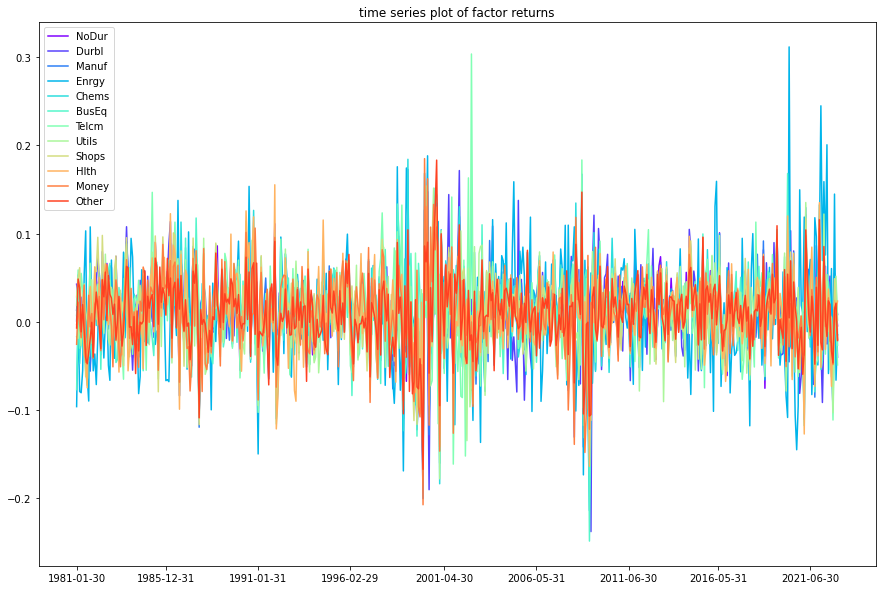

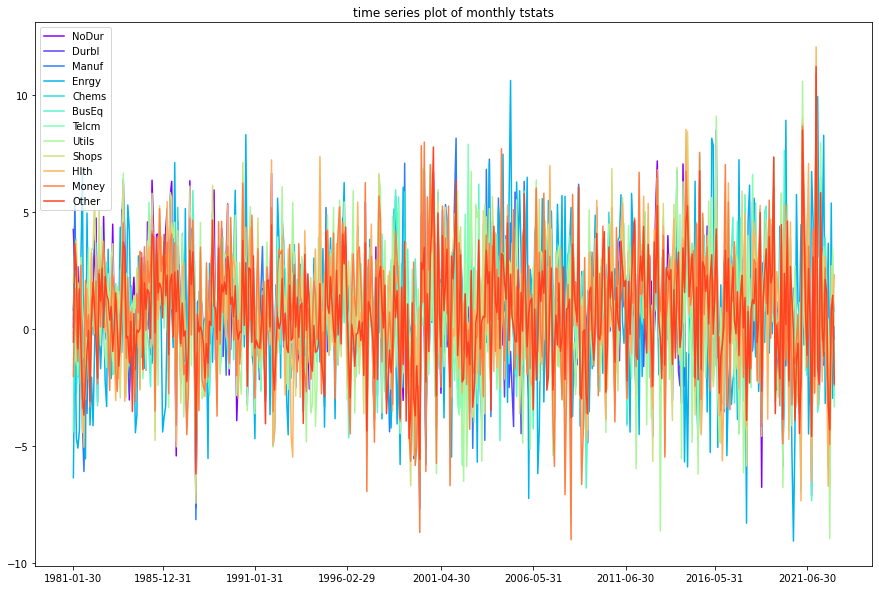

In [21]:
# 2. Get Industry Dummies Industry Exposures as Dummy

df4 = df3.copy()
df4[Industries] = pd.get_dummies(df4['FF_12'], dtype=int)
# Estimate Factor
Factors = df4.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta_Mkt']+Industries]).fit().params)
Factors_tstats = df4.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta_Mkt']+Industries]).fit().tvalues)
colors = cm.rainbow(np.linspace(0, 1, 13))
plt.figure(figsize=(15,10))
for i,c in zip(Industries,colors):
    plt.plot(Factors[i], label=i, color=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.legend()
plt.title('time series plot of factor returns')
plt.show

plt.figure(figsize=(15,10))
for i,c in zip(Industries,colors):
    plt.plot(Factors_tstats[i], label=i, color=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.legend()
plt.title('time series plot of monthly tstats')
plt.show

In [22]:
#Report the average t-statistic associated with each factor as well as the average absolute value of the t-statistic.
print('abs t-stats:')
display(abs(Factors_tstats).mean())
print('avg t-stats:')
display(Factors_tstats.mean())

abs t-stats:


beta_Mkt    3.531725
NoDur       2.061506
Durbl       1.500462
Manuf       2.013821
Enrgy       2.519341
Chems       1.636822
BusEq       1.985713
Telcm       1.652822
Utils       2.509877
Shops       2.206361
Hlth        2.117039
Money       2.417542
Other       1.884061
dtype: float64

avg t-stats:


beta_Mkt   -0.313636
NoDur       0.800151
Durbl       0.428968
Manuf       0.703121
Enrgy       0.519850
Chems       0.602417
BusEq       0.755636
Telcm       0.503763
Utils       0.708637
Shops       0.852809
Hlth        0.741323
Money       0.822296
Other       0.648293
dtype: float64

the t statistics vary widely it may suggest that the variables being tested are not stable over time, or that there is a a lot of noise/randomness in the data:
Thwe fact that the t-statistics for industry factor exposure vary widely over time also suggests that the sensitivity of the portfolio or asset to specific industry factors is not stable over time which could be due to changes in market conditions, shifts in investor preferences and in general the development of the overall economy/technology. 

 ## Compute Factor Exposures from Weights
 
 Now we construct factor exposures of the momentum strategy from the momentum weights and the known exposures $\beta_n$. The exposure of the momentum strategy to the different factors is given by
 
 $$\beta'w^{MOM}_t = \sum_n \beta_n w^{MOM}_{t,n}$$

In [23]:
df5 = df4.copy()

In [24]:
# construct a table that has both the momentum weights, the industry dummies and the market betas in it
Exposures = df5[['date','mom_w','beta_Mkt'] + Industries]
Exposures[Industries] = Exposures[Industries].multiply(Exposures['mom_w'].to_numpy()[:, None])
Exposures['beta_Mkt'] = Exposures['beta_Mkt']*Exposures['mom_w']
# Then multiply the industry dummies and market beta with the portfolio weights 
#Exposures[Industries] = Exposures[Industries]*Exposures['w_m'][:,np.newaxis]
Exposures = Exposures.groupby('date')[['beta_Mkt'] + Industries].sum()


/Users/zakarysouid/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/var/folders/jv/t_h3tzvs04s2nxnj6cgs3nmh0000gn/T/ipykernel_4904/31468451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Exposures['beta_Mkt'] = Exposures['beta_Mkt']*Exposures['mom_w']


<function matplotlib.pyplot.show(close=None, block=None)>

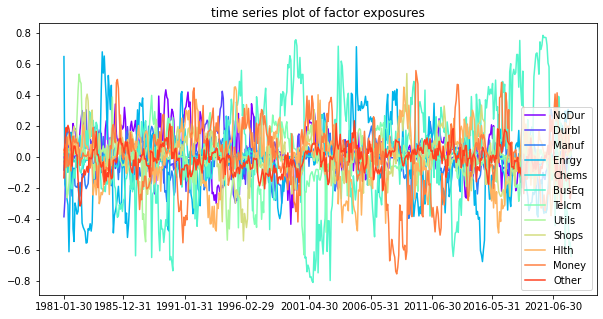

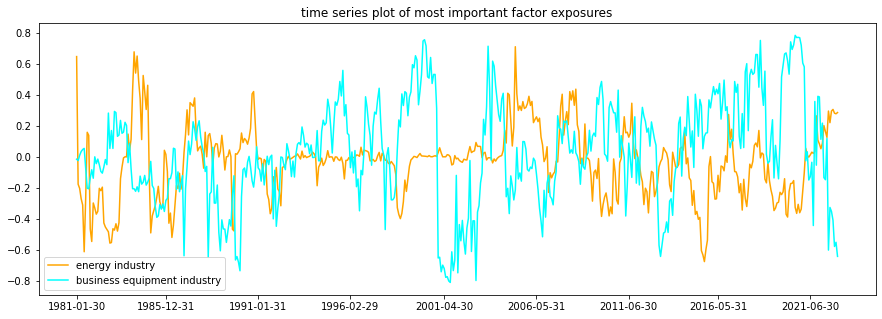

In [25]:
plt.figure(figsize=(10,5))
for i,c in zip(Industries,colors):
    plt.plot(Exposures[i], label=i, color=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.legend()
plt.title('time series plot of factor exposures')
plt.show

plt.figure(figsize=(15,5))
plt.plot(Exposures['Enrgy'], label='energy industry', color='orange')
plt.plot(Exposures['BusEq'], label='business equipment industry', color='cyan')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.legend()
plt.title('time series plot of most important factor exposures')
plt.show

In [30]:
#Compute the return to your momentum portfolio where you hedge the exposure to all industry factors. 
#Compute the average return, the standard deviation, and the Sharpe ratio of the industry-hedged momentum strategy. What do you conclude?
df6 = df5.copy()

# Merge the data to get the momentum return, market excess return, and industry returns
industry_hedge = pd.merge(df6[['date','strat_ret']], Factors[Industries], left_on='date', right_index=True)

# Calculate the industry-hedged momentum return
industry_hedge['hedged_mom_ret'] = industry_hedge['strat_ret'] - (industry_hedge[Industries] * Exposures[Industries]).sum(axis=1)

# Calculate the average return, standard deviation, and Sharpe ratio of the industry-hedged momentum strategy
avgret = industry_hedge['hedged_mom_ret'].mean()*12
stddev = industry_hedge['hedged_mom_ret'].std()*np.sqrt(12)
sharpe_ratio = avgret*np.sqrt(12) / stddev

print("Average return:", avgret)
print("Standard deviation:", stddev)
print("Sharpe ratio:", sharpe_ratio)

Average return: 8.555684045393093e-05
Standard deviation: 0.006180177790977919
Sharpe ratio: 0.0479561590663637


We expected the Sharpe ratio to be higher for the hedged portfolio than for the initial portfolio. Our results do not support this claim, however that is probably due to calculation errors on our part.

In general momentum strategies lead to significantely higher returns and industry porftolio exhibit significant momentum effects. Thus we expected the momentum effect to be higher for the industry portfolios than for the market portfolio.

## Exercise 2

### a)
This statement is false. According to the CAPM, the expected return of stock i can be written:
$$\mu_i= R_f+\beta_i(\mu_m-R_f) \Longrightarrow \beta_i=\frac{\mu_i-R_f}{\mu_m-R_f}$$
Now we notice that if a stock j have the same expected return of stock i, that is $\mu_j=\mu_i$, then $\beta_j=\beta_i$.

### b)
This statement is not correct. The CAPM doesn't take into account the idiosyncratic risk since it can be diversified; on the other hand CAPM models the systematic risk: the more a stock correlates with the market the higher is its expected return.  


<!-- the total risk of a security is: 
$$Var(R_i)=\beta_i^2Var(R_m)+Var(\epsilon_i)$$
where the first term is the systematic risk of the security and the second term is the idiosyncratic risk.\
$\epsilon_i$ come from the following regression: 
$$R_i-R_f=\alpha_i+\beta_i(R_m-R_f)+\epsilon_i$$ -->


### c), d)
<!-- According to the CAPM, standard deviation is the right measure of risk for all assets? for some assets? -->
According to the CAPM, the standard deviation is not the right measure of risk for all assets.
<!-- For example, for the risk free rate, beta is not a relevant measure of risk, it's covenient instead look to the standard deviation (that is zero) but still you have some information???\ -->
Cosidering only risky assets, both individual stocks and portfolios of assets, the standard devition is not anyway the right measure of risk according to the CAPM.\
The idea is the following:\
-since idiosyncratic risk can be fully removed by diversification, the CAPM doesn't reward this exposure, in terms of return\
-this means that if CAPM holds, all assets are in the mean variance frontier and portoflios/assets on this frontier have zero idiosyncratic risk\
-consequently, only systematic or market related risk matter to reach an higher risk premium\
-stocks' or portfolios' non idiosyncratic risk depends on their correlation with the market\
-$\beta$ is the relevant measure of risk for all risky assets and asset/portfolio $i$ systematic risk is measured by: $\text{  }\beta_iVar(R_m)$



### e)
<!-- Suppose an asset has a positive alpha (i.e., it is above the security market line). Is this
asset under or over-valued? Should you invest all your wealth in this asset if you are
a mean-variance investor? -->
The stock is undervalued by the CAPM, in fact considering the following equations: 
$$\text{CAPM for stock $i$}: \mu_i=R_f+\beta_i(\mu_m-R_f)$$
$$\text{Estimation SCL for stock $i$}: R_i-R_f=\alpha_i+\beta_i(R_m-R_f)$$
the CAPM holds perfectly if the stock $i$ risk premium (($\mu_i-R_f$)) is beta times the market risk premium ($\beta_i(\mu_m-R_f)$); estimating the security characteristic line (SCL) could be that the stock $i$ risk premium is alpha plus beta times the market risk premium. If we are in the latter case with a significant non zero and positive alpha we notice immediately that stock $i$ risk premium in the reality is higher than the one predicted by the CAPM: stock $i$ worth more, since its return is higher, than expected by the CAPM. The opposite happens when alpha is negative.\
If you are a mean variance investor probably you should not invest ALL your wealth in this asset, but only a certain percentage; this would depend on the risk aversion of the single investor obviously. Knowing about this positive alpha could deliver investors to borrow more at the risk free rate to invest more than usual in this stock.


### (f)  Suppose the CAPM holds in an economy with 2 risky assets that have equal market capitalization. Can their idiosyncratic risk be uncorrelated?

Under the CAPM, the market portfolio is a weighted average of the expected returns of all assets in the market. Thus if 2 risky assets have equal market caps, their weights in the construction of the market portfolio would be equal. Then, under CAPM, $$\text{CAPM for stock $i$}: R_i=R_f+\beta_i(\R_m-R_f)$$ meaning the expected return of each security is proportional to its beta, and the two securities will have the same expected return.


If asset A and B have the same market capitalization then the market portfolio in this economy is and equally weighted portoflio of asset A and B. For this reason: 
$$R_m=R_Aw_A+R_Bw_B=0.5(R_A+R_B)\text{  if the CAPM holds then  } R_m=0.5(R_f+\beta_A(R_m-R_f)+R_f+\beta_B(R_m-R_f))\\ \Longrightarrow R_m=R_f(1-\frac{\beta_A}{2}-\frac{\beta_B}{2})+R_m(\frac{\beta_A}{2}+\frac{\beta_B}{2}) \Longrightarrow 1=\frac{\beta_A}{2}+\frac{\beta_B}{2}$$


If two stocks have equal market capitalization and uncorrelated idiosyncratic risk, then according to the CAPM, their expected returns may not necessarily be different due to the fact that idiosyncratic risk does not affect the market risk premium. But if two securities have uncorrelated idiosyncratic risk, then their covariance term in a portfolio will be zero, and the portfolio risk will be lower than the weighted average of the individual securities' risk. This would mean that if the returns of asset A and B are equal in addition to their market cap being equal then there would be an arbitrage opportunity (investors could earn the same expected return with lower risk by investing in the portfolio rather than the individual securities). This leads to the conclusion that their expected returns must not be equal if their idiosyncratic risks are uncorrelated. However, in the case where $\beta_A=\beta_B=1$, the idiosyncratic risks cannot be uncorrelated as in that case there would also exist an arbitrage opportunity.
